In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
import numpy as np
import copy
import matplotlib.pyplot as plt

In [2]:
seed = 34
torch.manual_seed(seed)
np.random.seed(seed)

$$
B_6(x_1, x_2, x_3, x_4, x_5, x_6) = x_1^6 + 15x_2x_1^4 + 20x_3x_1^3 + 45x_2^2x_1^2 + 15x_2^3 + 60x_3x_2x_1 + 15x_4x_1^2 + 10x_3^2 + 15x_4x_2 + 6x_5x_1 + x_6
$$

In [3]:
def B_6(X):
    x1, x2, x3, x4, x5, x6 = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5]
    return (x1**6 + 15*x2*x1**4 + 20*x3*x1**3 + 45*x2**2*x1**2 + 15*x2**3 +
            60*x3*x2*x1 + 15*x4*x1**2 + 10*x3**2 + 15*x4*x2 + 6*x5*x1 + x6)

$$
\tilde{B}_6(x_1, x_2, x_3, x_4, x_5, x_6)
=\;
{x_6^6}{(1)}
+\; {15\,x_4^4\,x_5}
+\; {20\,x_1^3\,x_2}
+\; {45\,x_3^2\,x_4^2}
+\; {15\,x_5^3}
+\; {60\,x_6\,x_1\,x_4}
+\; {15\,x_2^2\,x_3}
+\; {10\,x_1^2}
+\; {15\,x_3\,x_6}
+\; {6\,x_2\,x_5}
+\; {x_2}
$$

In [4]:
def B_tilde_6(X):
    x1, x2, x3, x4, x5, x6 = X[:, 0], X[:, 1], X[:, 2], X[:, 3], X[:, 4], X[:, 5]
    return (x6**6 + 15*x4*x5**4 + 20*x2*x1**3 + 45*x3**2*x4**2 + 15*x5**3 +
            60*x6*x1*x4 + 15*x3*x2**2 + 10*x1**2 + 15*x3*x6 + 6*x5*x2 + x2)

In [5]:
# Number of test examples
TEST_SIZE = 60_000
TRAIN_SIZE = 100_000
INPUT_SIZE = 6
OUTPUT_SIZE = 1
BATCH_SIZE = 256
EPOCHS = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Training on device: {DEVICE}")

Training on device: mps


In [6]:

# Generate inputs for hierarchical model
X_train_h = 2 * torch.rand(TRAIN_SIZE, 6)  # shape: (100000, 6)
X_test_h = 2 * torch.rand(TEST_SIZE, 6)  # shape: (60000, 6)

result_train = B_6(X_train_h)
result_test = B_6(X_test_h)

In [7]:
# Generate inputs for scrambled model
X_train_tilde = 2 * torch.rand(TRAIN_SIZE, 6)  # shape: (100000, 6)
X_test_tilde = 2 * torch.rand(TEST_SIZE, 6)  # shape: (60000, 6)

result_train_tilde = B_tilde_6(X_train_tilde)
result_test_tilde = B_tilde_6(X_test_tilde)

In [8]:
train_set_h = TensorDataset(X_train_h, result_train)
test_set_h = TensorDataset(X_test_h, result_test)

train_set_scrambled = TensorDataset(X_train_tilde, result_train_tilde)
test_set_scrambled = TensorDataset(X_test_tilde, result_test_tilde)

In [9]:
train_loader_h = DataLoader(train_set_h, batch_size=BATCH_SIZE, shuffle=True)
test_loader_h = DataLoader(test_set_h, batch_size=BATCH_SIZE, shuffle=False)

train_loader_scrambled = DataLoader(train_set_scrambled, batch_size=BATCH_SIZE, shuffle=True)
test_loader_scrambled = DataLoader(test_set_scrambled, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, hidden_size):
        super(ResBlock, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU()
        )

    def forward(self, x):
        return x + self.layer(x)  # Residual connection

class ResNet(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=50, num_hidden_layers=7):
        super(ResNet, self).__init__()
        
        # Input layer (no residual connection because size changes)
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU()
        )

        # Hidden layers with residual connections
        self.hidden_layers = nn.Sequential(*[ResBlock(hidden_size) for _ in range(num_hidden_layers)])

        # Output layer (no residual connection because size changes)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.input_layer(x)  # First layer (no residual)
        x = self.hidden_layers(x)  # Residual connections in hidden layers
        x = self.output_layer(x)  # Last layer (no residual)
        return x

In [11]:
def train(
    model, 
    train_loader,
    test_loader,
    optimizer=optim.Adam,
    lr=1e-3,
    num_epochs=30, 
    log_interval=1,
    verbose=True,
    device='cpu'
):
    """
    Train the model using MSE loss with Adam optimizer, with optional tqdm progress bar.

    Args:
        model: PyTorch model to train.
        train_loader: Training DataLoader.
        test_loader: Test DataLoader.
        lr: Learning rate.
        batch_size: Batch size (not used explicitly but assumed to be in DataLoader).
        num_epochs: Number of training epochs.
        log_interval: Interval for printing epoch summary.
        verbose: If False, hides tqdm progress bar and per-epoch prints.

    Returns:
        train_losses: List of training losses per epoch.
        test_losses: List of test losses per epoch.
    """
    model.to(device)

    if verbose:
        print(f"Training on device: {device}")
    
    # Define optimizer and loss function

    weight_decay = 1e-5
    betas = (0.9, 0.999)

    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay, betas=betas)
    criterion = nn.MSELoss()

    train_losses = []
    test_losses = []

    progress_bar = tqdm(range(num_epochs), desc='Training', leave=False, disable=verbose)

    for epoch in progress_bar:
        model.train()  # Set model to training mode
        epoch_train_loss = 0.0
        num_batches = 0

        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False, disable=not verbose)
        for X_batch, y_batch in loop:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            y_pred = model(X_batch).squeeze()
            loss = criterion(y_pred, y_batch)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track training loss
            epoch_train_loss += loss.item()
            num_batches += 1
        
        # Average training loss for the epoch
        epoch_train_loss /= num_batches

        # Evaluate on the test set
        model.eval()
        test_loss_total = 0.0
        num_test_batches = 0
        with torch.no_grad():
            for X, y in test_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X).squeeze()
                test_loss_total += criterion(y_pred, y).item()
                num_test_batches += 1
        
        # Compute mean test loss
        epoch_test_loss = test_loss_total / num_test_batches

        train_losses.append(epoch_train_loss)
        test_losses.append(epoch_test_loss)

        # Print at given interval only if verbose=True
        if verbose and (epoch + 1) % log_interval == 0:
            print(f"Epoch {epoch+1}/{num_epochs}: "
                  f"Train Loss = {epoch_train_loss:.6f}, "
                  f"Test Loss = {epoch_test_loss:.6f}")

    return train_losses, test_losses


In [12]:
def find_best_lr(
    model_constructor,
    lrs,
    train_loader,
    test_loader,
    num_epochs=30,
    log_interval=1,
    verbose=False,
    device='cpu'
):
    """
    Search for the best learning rate among a list of values.
    
    Args:
        model_constructor: a function or callable that returns a *new* untrained model.
                          e.g. `lambda: FullyConnectedResidualNetwork(6, 1)`
        lrs: list of learning rate values to test
        X_train, y_train: training dataset
        X_test, y_test: test dataset
        batch_size, num_epochs, log_interval: passed to the `train` function

    Returns:
        best_lr: the learning rate that produced the best (lowest) final test loss
        best_model: a model instance trained with the best_lr
        best_loss: the final test loss achieved by best_model
    """
    best_lr = None
    best_loss = float("inf")
    best_model_state = None
    best_tr_losses = None
    best_te_losses = None

    for lr in lrs:
        print(f"\n[LR SEARCH] Testing lr={lr}")
        # 1) Create a fresh model each time
        model = model_constructor()

        # 2) Train model with your existing train() function
        train_losses, test_losses = train(
            model,
            train_loader,
            test_loader,
            lr=lr,
            num_epochs=num_epochs,
            log_interval=log_interval,
            verbose=verbose,
            device=device
        )

        # 3) Compute final test loss for this lr
        final_test_loss = test_losses[-1]  # last epoch's test loss

        print(f"[LR SEARCH] lr={lr} -> Final Test Loss = {final_test_loss:.6f}\nTest Ended.")

        # 4) Check if it's the best so far
        if final_test_loss < best_loss:
            best_loss = final_test_loss
            best_lr = lr
            best_tr_losses = train_losses
            best_te_losses = test_losses
            # Save model weights
            best_model_state = copy.deepcopy(model.state_dict())

    # 5) Build a final model with the best weights
    best_model = model_constructor()
    best_model.load_state_dict(best_model_state)

    print(f"\nBest LR = {best_lr} with Final Test Loss = {best_loss:.6f}")
    return best_lr, best_model, best_loss, best_tr_losses, best_te_losses

In [13]:
model_constructor = lambda: ResNet(6, 1)
candidate_lrs = [5e-5, 1e-4, 3e-4]

In [14]:
h_best_lr, _, h_best_loss, _, _ = find_best_lr(
    model_constructor,
    candidate_lrs,
    train_loader_h,
    test_loader_h,
    num_epochs=30,
    log_interval=1,
    verbose=False,
)
print("Chosen LR:", h_best_lr)
print("Best final test loss:", h_best_loss)


[LR SEARCH] Testing lr=5e-05


Training:   0%|          | 0/30 [00:00<?, ?it/s]

[LR SEARCH] lr=5e-05 -> Final Test Loss = 42.104915
Test Ended.

[LR SEARCH] Testing lr=0.0001


Training:   0%|          | 0/30 [00:00<?, ?it/s]

[LR SEARCH] lr=0.0001 -> Final Test Loss = 21.499411
Test Ended.

[LR SEARCH] Testing lr=0.0003


Training:   0%|          | 0/30 [00:00<?, ?it/s]

[LR SEARCH] lr=0.0003 -> Final Test Loss = 12.213260
Test Ended.

Best LR = 0.0003 with Final Test Loss = 12.213260
Chosen LR: 0.0003
Best final test loss: 12.2132598917535


In [15]:
scrambled_best_lr, _, scrambled_best_loss, _, _ = find_best_lr(
    model_constructor,
    candidate_lrs,
    train_loader_scrambled,
    test_loader_scrambled,
    num_epochs=30,
    log_interval=1,
    verbose=False
)
print("Chosen LR:", scrambled_best_lr)
print("Best final test loss:", scrambled_best_loss)


[LR SEARCH] Testing lr=5e-05


Training:   0%|          | 0/30 [00:00<?, ?it/s]

[LR SEARCH] lr=5e-05 -> Final Test Loss = 169.742705
Test Ended.

[LR SEARCH] Testing lr=0.0001


Training:   0%|          | 0/30 [00:00<?, ?it/s]

[LR SEARCH] lr=0.0001 -> Final Test Loss = 73.615897
Test Ended.

[LR SEARCH] Testing lr=0.0003


Training:   0%|          | 0/30 [00:00<?, ?it/s]

[LR SEARCH] lr=0.0003 -> Final Test Loss = 51.532420
Test Ended.

Best LR = 0.0003 with Final Test Loss = 51.532420
Chosen LR: 0.0003
Best final test loss: 51.532420430284866


In [16]:
h_best_lr = 1e-4
scrambled_best_lr = 1e-4

In [17]:
h_model = ResNet(6, 1)
h_train_losses, h_test_losses = train(
    h_model,
    train_loader_h,
    test_loader_h,
    lr=h_best_lr,
    num_epochs=50,
    log_interval=1,
    verbose=False,
    device=DEVICE
)

# Save the model
torch.save(h_model.state_dict(), "h_model.pth")

Training:   0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
scr_model = ResNet(6, 1)
scr_train_losses, scr_test_losses = train(
    scr_model,
    train_loader_scrambled,
    test_loader_scrambled,
    lr=scrambled_best_lr,
    num_epochs=50,
    log_interval=1,
    verbose=False,
    device=DEVICE
)

# Save the model
torch.save(scr_model.state_dict(), "scr_model.pth")

Training:   0%|          | 0/50 [00:00<?, ?it/s]

In [19]:
def final_test_evaluation(model, X_test, y_test, device='cpu'):
    """
    Evaluate the trained model on the test set and return the MSE.
    """
    
    model.to(device)
    model.eval()  # Set to evaluation mode

    criterion = nn.MSELoss()

    with torch.no_grad():
        X_test_dev = X_test.to(device)
        y_test_dev = y_test.to(device)
        y_pred = model(X_test_dev).squeeze()
        test_loss = criterion(y_pred, y_test_dev).item()

    return test_loss

In [20]:
# Evaluate final test error:
h_final_test_loss = final_test_evaluation(h_model, X_test_h, result_test)
print(f"Final generalisation error hierarchical model: {h_final_test_loss:.3f}")
# Evaluate final test error:
scrambled_final_test_loss = final_test_evaluation(scr_model, X_test_tilde, result_test_tilde)
print(f"Final generalisation error scrambled model: {scrambled_final_test_loss:.3f}")

Final generalisation error hierarchical model: 11.964
Final generalisation error scrambled model: 55.526


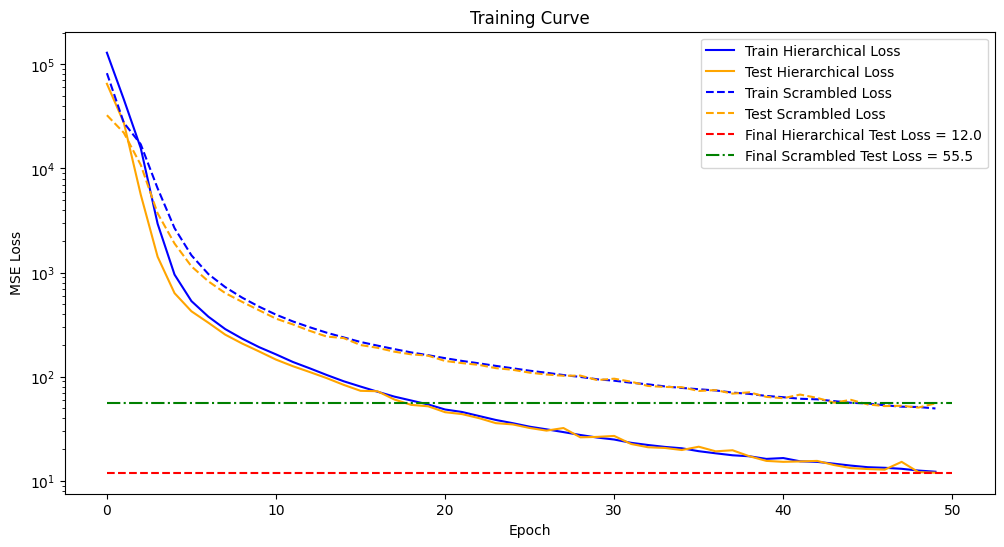

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(h_train_losses, label="Train Hierarchical Loss", color='blue')
plt.plot(h_test_losses, label="Test Hierarchical Loss", color='orange')
plt.plot(scr_train_losses, label="Train Scrambled Loss", color='blue', linestyle='--')
plt.plot(scr_test_losses, label="Test Scrambled Loss", color='orange', linestyle='--')
plt.hlines(h_final_test_loss, 0, len(h_train_losses), linestyles='dashed', color='red', label=f"Final Hierarchical Test Loss = {h_final_test_loss:.1f}")
plt.hlines(scrambled_final_test_loss, 0, len(h_train_losses), linestyles='dashdot',color='green', label=f"Final Scrambled Test Loss = {scrambled_final_test_loss:.1f}")
plt.legend()
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training Curve")
plt.savefig("training_curve.png")
plt.show()

In [22]:
def plot_sweep_single(
    model, 
    polynomial_fn, 
    device='cpu', 
    n_points=100
):
    """
    1) Samples a single random vector x in [0,2]^6.
    2) For each dimension i, creates a grid of size n_points over [0,2] 
       and keeps other dimensions fixed to x.
    3) Evaluates both the polynomial and the model, then plots them.
    """
    model.eval()
    model.to(device)

    # 1) Sample a single random x in [0,2]^6
    x = 2 * torch.rand(6)  # shape (6,)
    
    # We'll do one figure per input dimension for clarity
    for i in range(6):
        # 2) Build the 1D sweep grid for x_i
        sweep_vals = torch.linspace(0, 2, n_points)
        
        # Create an (n_points x 6) tensor, each row is a copy of x
        X_sweep = x.repeat(n_points, 1)  # shape (n_points, 6)
        # Overwrite the i-th column with the sweep values
        X_sweep[:, i] = sweep_vals
        
        # 3) Evaluate polynomial
        with torch.no_grad():
            y_poly = polynomial_fn(X_sweep)  # shape (n_points,)
        
        # 3) Evaluate model
        X_sweep_dev = X_sweep.to(device)
        with torch.no_grad():
            y_model = model(X_sweep_dev).squeeze().cpu()  # shape (n_points,)
        
        # Plot
        plt.figure(figsize=(6,4))
        plt.plot(sweep_vals, y_poly.numpy(), label='Polynomial', color='blue')
        plt.plot(sweep_vals, y_model.numpy(), label='Model', color='red', linestyle='--')
        plt.xlabel(f"x_{i+1}")
        plt.ylabel("Output")
        plt.title(f"Sweep over x_{i+1} (others fixed)")
        plt.legend()
        plt.tight_layout()
        plt.show()

def plot_sweep_multiple(
    model, 
    polynomial_fn, 
    device='cpu', 
    n_sweeps=5, 
    n_points=100
):
    """
    Repeats the single sweep process n_sweeps times and aggregates the results.
    The function returns the arrays used for plotting, so you can 
    further analyze or plot an average curve if you like.
    """
    model.eval()
    model.to(device)
    
    # We'll store results in a dictionary keyed by dimension i
    # Each entry will store lists of curves from multiple sweeps.
    sweep_data = {
        i: {'grid': None, 'poly_vals': [], 'model_vals': []}
        for i in range(6)
    }
    
    for sweep_idx in range(n_sweeps):
        # Sample a random x in [0,2]^6
        x = 2 * torch.rand(6)
        
        for i in range(6):
            # Build the grid
            sweep_vals = torch.linspace(0, 2, n_points)
            
            # Create input matrix for this sweep
            X_sweep = x.repeat(n_points, 1)
            X_sweep[:, i] = sweep_vals
            
            with torch.no_grad():
                # Evaluate polynomial
                y_poly = polynomial_fn(X_sweep)
                
                # Evaluate model
                X_sweep_dev = X_sweep.to(device)
                y_model = model(X_sweep_dev).squeeze().cpu()
            
            # Store results
            sweep_data[i]['poly_vals'].append(y_poly.numpy())
            sweep_data[i]['model_vals'].append(y_model.numpy())
            
            # Store the grid once
            if sweep_data[i]['grid'] is None:
                sweep_data[i]['grid'] = sweep_vals.numpy()
    
    # Optionally, we can compute an average or median across sweeps:
    for i in range(6):
        # Convert list of arrays to a 2D numpy array: shape (n_sweeps, n_points)
        poly_matrix = np.array(sweep_data[i]['poly_vals'])
        model_matrix = np.array(sweep_data[i]['model_vals'])
        
        poly_mean = poly_matrix.mean(axis=0)
        model_mean = model_matrix.mean(axis=0)
        
        # Plot the average
        plt.figure(figsize=(6,4))
        plt.plot(sweep_data[i]['grid'], poly_mean, label='Polynomial (avg)', color='blue')
        plt.plot(sweep_data[i]['grid'], model_mean, label='Model (avg)', color='red', linestyle='--')
        plt.xlabel(f"x_{i+1}")
        plt.ylabel("Output")
        plt.title(f"Avg Sweep over x_{i+1} across {n_sweeps} random x")
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    return sweep_data

In [23]:
def plot_sweep_single_grid(
    model, 
    polynomial_fn, 
    device='cpu', 
    n_points=100
):
    """
    1) Samples ONE random vector x in [0,2]^6.
    2) For each dimension i, creates a grid of n_points over [0,2],
       while keeping the other components fixed.
    3) Evaluates both the polynomial and the model and plots them in 
       a single figure with 1 row and 6 subplots, each with its own y-axis.
    """
    model.eval()
    model.to(device)

    # Sample one random input vector x in [0,2]^6.
    x = 2 * torch.rand(6)
    
    # Create a figure with 1 row and 6 columns (each subplot gets its own y-axis).
    fig, axes = plt.subplots(1, 6, figsize=(24, 4))
    
    for i in range(6):
        sweep_vals = torch.linspace(0, 2, n_points)
        
        # Create a batch where all rows are x, but replace the i-th dimension.
        X_sweep = x.repeat(n_points, 1)
        X_sweep[:, i] = sweep_vals
        
        # Evaluate the polynomial
        with torch.no_grad():
            y_poly = polynomial_fn(X_sweep)
        
        # Evaluate the model
        with torch.no_grad():
            y_model = model(X_sweep.to(device)).squeeze().cpu()
        
        # Plot on the corresponding subplot
        ax = axes[i]
        ax.plot(sweep_vals.numpy(), y_poly.numpy(), label='Polynomial', color='blue')
        ax.plot(sweep_vals.numpy(), y_model.numpy(), label='Model', color='red', linestyle='--')
        ax.set_xlabel(f"x_{i+1}")
        ax.set_title(f"Sweep over x_{i+1}")
        ax.legend()
    
    plt.tight_layout()
    plt.show()

def plot_sweep_multiple_grid(
    model, 
    polynomial_fn, 
    device='cpu', 
    n_sweeps=5, 
    n_points=100,
    save_path=None
):
    """
    1) Repeats the single-sweep process n_sweeps times, each time sampling a new x in [0,2]^6.
    2) For each dimension i, collects polynomial and model outputs across sweeps and computes the average.
    3) Plots the averaged curves in a single figure with 1 row and 6 subplots, each with its own y-axis.
    """
    model.eval()
    model.to(device)
    
    # Prepare containers for outputs for each dimension.
    poly_vals_per_dim = [[] for _ in range(6)]
    model_vals_per_dim = [[] for _ in range(6)]
    grid = None

    for sweep_idx in range(n_sweeps):
        # Sample a random x in [0,2]^6.
        x = 2 * torch.rand(6)
        for i in range(6):
            sweep_vals = torch.linspace(0, 2, n_points)
            X_sweep = x.repeat(n_points, 1)
            X_sweep[:, i] = sweep_vals

            # Evaluate the polynomial
            with torch.no_grad():
                y_poly = polynomial_fn(X_sweep)
            
            # Evaluate the model
            with torch.no_grad():
                y_model = model(X_sweep.to(device)).squeeze().cpu()
            
            poly_vals_per_dim[i].append(y_poly.numpy())
            model_vals_per_dim[i].append(y_model.numpy())
            
            # Store the sweep grid (only once)
            if grid is None:
                grid = sweep_vals.numpy()
    
    # Now average the curves over all sweeps.
    fig, axes = plt.subplots(1, 6, figsize=(24, 4))
    
    for i in range(6):
        poly_array = np.array(poly_vals_per_dim[i])   # shape: (n_sweeps, n_points)
        model_array = np.array(model_vals_per_dim[i])
        
        # Compute the mean curve.
        poly_mean = poly_array.mean(axis=0)
        model_mean = model_array.mean(axis=0)
        
        ax = axes[i]
        ax.plot(grid, poly_mean, label='Polynomial (avg)', color='blue')
        ax.plot(grid, model_mean, label='Model (avg)', color='red', linestyle='--')
        ax.set_xlabel(f"x_{i+1}")
        ax.set_title(f"Avg sweep over x_{i+1}")
        ax.legend()
    
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()
    
    return {
        'grid': grid,
        'poly_means': [np.array(poly_vals_per_dim[i]).mean(axis=0) for i in range(6)],
        'model_means': [np.array(model_vals_per_dim[i]).mean(axis=0) for i in range(6)]
    }

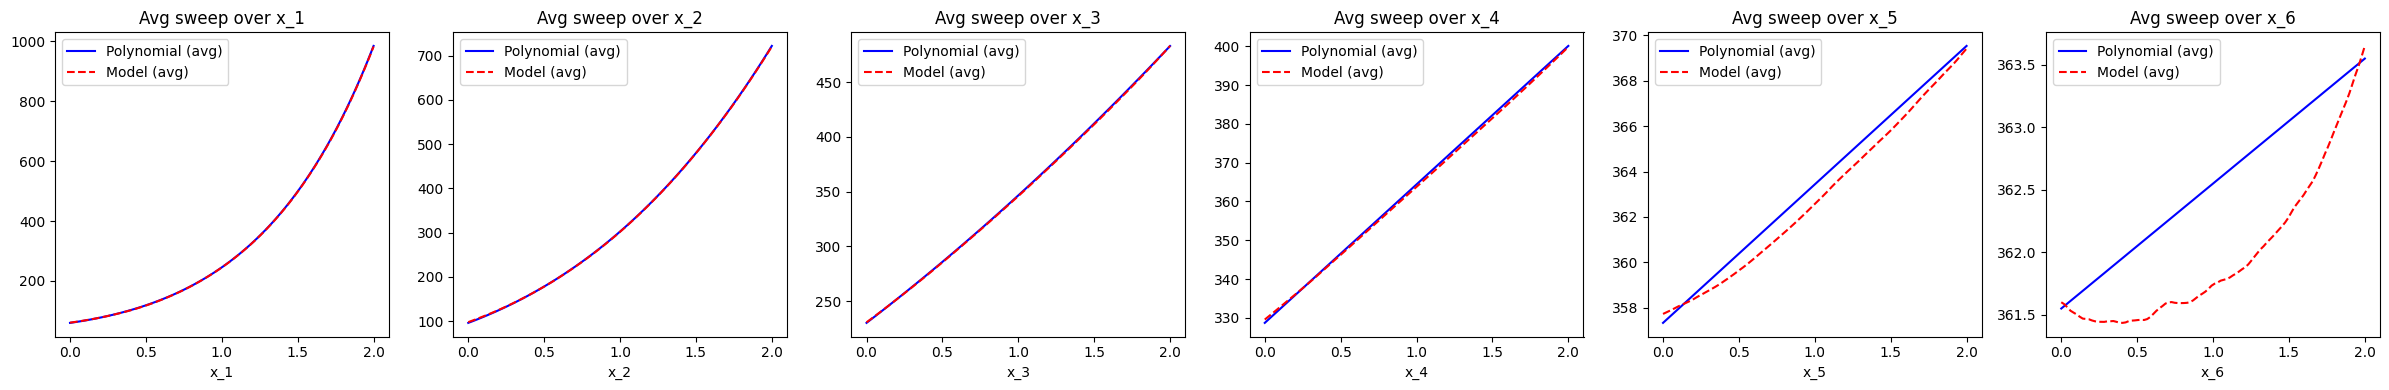

In [24]:
sweep_data = plot_sweep_multiple_grid(h_model, B_6, device=DEVICE, n_sweeps=100, n_points=100, save_path="sweep_h.png")

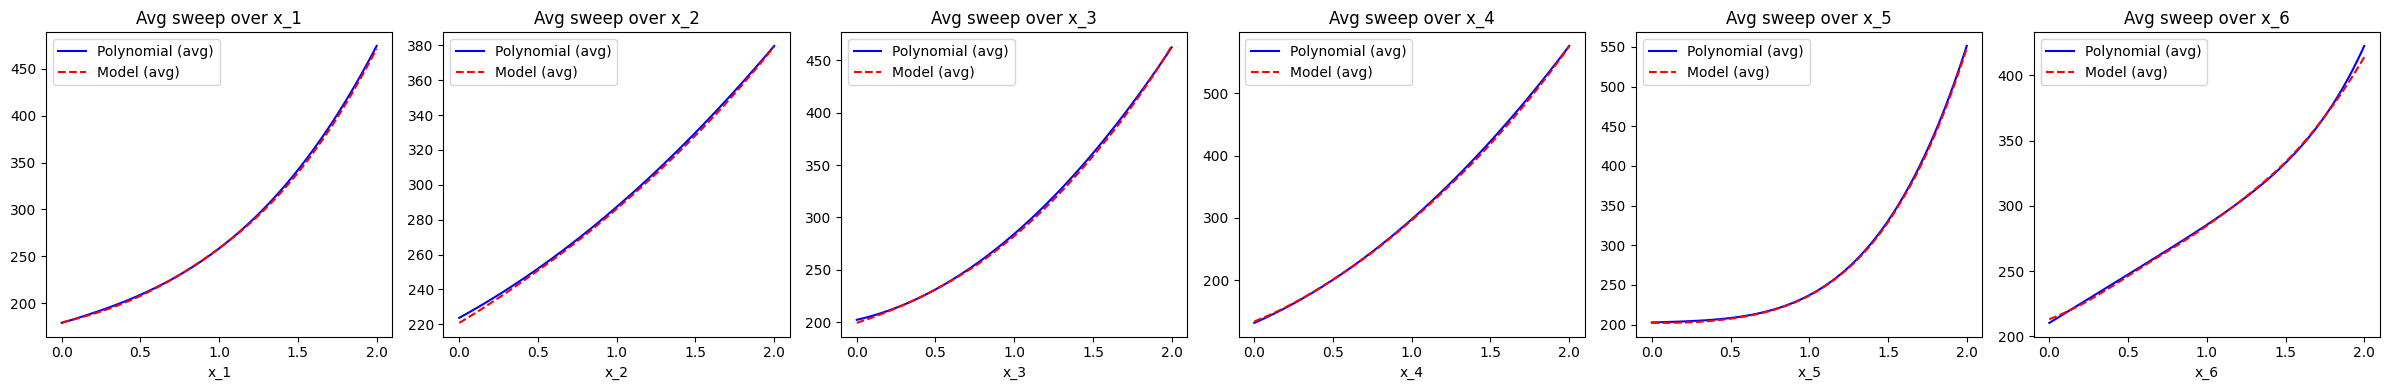

In [25]:
sweep_data_scr = plot_sweep_multiple_grid(scr_model, B_tilde_6, device=DEVICE, n_sweeps=100, n_points=100, save_path="sweep_scr.png")